In [6]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from mdgp.bo_experiment.experiment import ExperimentConfig
import warnings 

In [7]:
def flatten_dict(d, parent_key=''):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}.{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key).items())
        else:
            items.append((new_key, v))
    return dict(items)


def read_config(path) -> pd.DataFrame:
    return pd.DataFrame([flatten_dict(ExperimentConfig.from_json(path).to_dict())])


def collect_and_combine_dataframes(dir_path, config_file_name='config.json', metrics_file_name='bo/metrics.csv'):
    # List to hold dataframes
    dfs = []
    
    # Walking through the directory tree
    for root, dirs, files in os.walk(dir_path):
        # print(files)
        if config_file_name in files:
            # Constructing the file paths
            config_file_path = os.path.join(root, config_file_name)
            metrics_file_path = os.path.join(root, metrics_file_name)
            
            if os.path.exists(metrics_file_path) is False: 
                continue

            # Reading the files into dataframes
            config_df = read_config(config_file_path)
            metrics_df = pd.read_csv(metrics_file_path)
            config_df = pd.concat([config_df] * len(metrics_df), ignore_index=True)
            
            # Joining the dataframes
            joined_df = config_df.join(metrics_df)
            
            # Appending the joined dataframe to the list
            dfs.append(joined_df)
    
    # Combining all the joined dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

In [8]:
df = collect_and_combine_dataframes('../../experiments/bo/')
df = df[[
    'best_y', 
    'run', 
    'step', 
    'model_arguments.model_name', 
    'bo_arguments.switch_to_deep_iter', 
    'data_arguments.target_function_name', 
    'model_arguments.acqf_name',
    'bo_arguments.kmeans_inducing',
]].astype({'best_y': 'float64', 'run': int, 'step': int})

In [9]:
# Find the approximate minimum of the perm_sph_harm function 
import torch
from mdgp.bo_experiment import DataArguments
from mdgp.utils import sphere_uniform_grid

torch.set_default_dtype(torch.float64)
target_function = DataArguments(target_function_name='perm_sph_harm').target_function
x = sphere_uniform_grid(100000)
x = x + torch.tensor([[0., 0., 1.]]) * 100000000
x = x / x.norm(dim=-1, keepdim=True)
perm_sph_harm_min = target_function(x).min().item()

In [10]:
df['best_y'][df['data_arguments.target_function_name'] == 'perm_sph_harm'].min()

-0.7820286966899537

In [11]:
def log10_simple_regret(x, minimum=0):
    return np.log10(x - minimum)
df['best_y'][df['data_arguments.target_function_name'] == 'perm_sph_harm'] -= perm_sph_harm_min
df['simple_regret'] = log10_simple_regret(df['best_y'])

/tmp/ipykernel_999/593482273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['best_y'][df['data_arguments.target_function_name'] == 'perm_sph_harm'] -= perm_sph_harm_min
/home/kacperwyrwal/miniconda3/envs/mdgp_requirements_test7/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
ackley = df['data_arguments.target_function_name'] == 'ackley'
perm_sph_harm = df['data_arguments.target_function_name'] == 'perm_sph_harm'
exact = df['model_arguments.model_name'] == 'exact'
deep = df['model_arguments.model_name'] == 'deep'
ei = df['model_arguments.acqf_name'] == 'expected_improvement'
switch_to_deep_iter_180 = df['bo_arguments.switch_to_deep_iter'] == 180
run_10_max = df['run'] < 15
kmeans = df['bo_arguments.kmeans_inducing'] == True 

df = df[(ackley | perm_sph_harm) & (exact | (deep & switch_to_deep_iter_180 & kmeans)) & ei & run_10_max]

## Reproducing results from MaternGaBO

In [13]:
import matplotlib.pyplot as plt

# Enable LaTeX globally
plt.rcParams['text.usetex'] = True

# Set the font family to 'Computer Modern'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cm']

/tmp/ipykernel_999/3767403881.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df[perm_sph_harm & run_10_max]
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found f

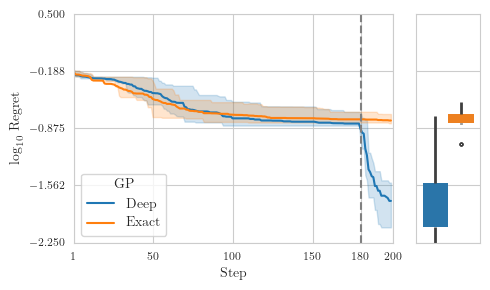

In [14]:
import matplotlib.gridspec as gridspec

data = df[perm_sph_harm & run_10_max]

# Set up the gridspec
plt.figure(figsize=(5, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1])

# Create the main line plot on the left
ax1 = plt.subplot(gs[0])
sns.lineplot(data=data, x='step', y='simple_regret', hue='model_arguments.model_name', estimator='mean', errorbar=('pi', 50), ax=ax1)

# Setting the y-axis range and ticks for the main plot
ax1.set_ylim(-2.25, 0.5)
ax1.set_yticks(np.linspace(-2.25, 0.5, 5))
ax1.set_xlim(1, 200)
ax1.set_xticks(np.linspace(1, 200, 5))

# Renaming the axes with updated font sizes for the main plot
ax1.set_xlabel("Step", fontsize=10)
ax1.set_ylabel("$\log_{10}$ Regret", fontsize=10)

# Update tick font sizes for the main plot
ax1.tick_params(labelsize=8)
ax1.set_xticks([1, 50, 100, 150, 180, 200])

ax1.axvline(180, linestyle='--', color='gray', linewidth=1.5)

# Boxplot styling
boxprops = dict(edgecolor='none')
whiskerprops = dict(linewidth=2)  # using black as a placeholder
medianprops = dict(color='none')
flierprops= dict(marker="o", markersize=2)

# Create the boxplot on the right
ax2 = plt.subplot(gs[1], sharey=ax1)
sns.boxplot(data=data[data['step'] == 199], y='simple_regret', hue='model_arguments.model_name', ax=ax2, 
            boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, showcaps=False, legend=False, 
            saturation=0.85, flierprops=flierprops)

# Modify the legend title
handles, labels = ax1.get_legend_handles_labels()
labels = ['Deep', 'Exact']
legend = ax1.legend(handles=handles, labels=labels)
legend.set_title("GP")

ax2.set(xticklabels=[], ylabel="", xlabel="")  # Remove x and y axis labels
for label in ax2.get_yticklabels():
    label.set_visible(False)
ax2.tick_params(left=False, bottom=False)  # Remove ticks

plt.tight_layout()
plt.show()


/tmp/ipykernel_999/2806301060.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df[ackley & run_10_max]
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the 

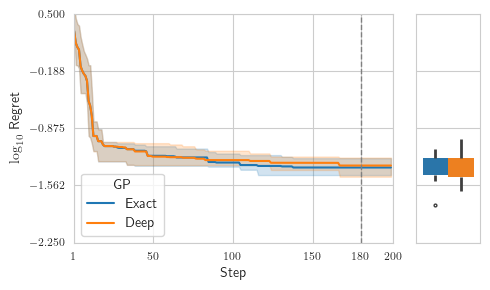

In [15]:
import matplotlib.gridspec as gridspec
sns.set_style("whitegrid")

data = df[ackley & run_10_max]

# Set up the gridspec
plt.figure(figsize=(5, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1])

# Create the main line plot on the left
ax1 = plt.subplot(gs[0])
sns.lineplot(data=data, x='step', y='simple_regret', hue='model_arguments.model_name', estimator='mean', errorbar=('pi', 50), ax=ax1)

# Setting the y-axis range and ticks for the main plot
ax1.set_ylim(-2.25, 0.5)
ax1.set_yticks(np.linspace(-2.25, 0.5, 5))
ax1.set_xlim(1, 200)
ax1.set_xticks(np.linspace(1, 200, 5))

# Renaming the axes with updated font sizes for the main plot
ax1.set_xlabel("Step", fontsize=10)
ax1.set_ylabel("$\log_{10}$ Regret", fontsize=10)

# Update tick font sizes for the main plot
ax1.tick_params(labelsize=8)
ax1.set_xticks([1, 50, 100, 150, 180, 200])

ax1.axvline(180, linestyle='--', color='gray', linewidth=1)

# Boxplot styling
boxprops = dict(edgecolor='none')
whiskerprops = dict(linewidth=2)  # using black as a placeholder
medianprops = dict(color='none')
flierprops= dict(marker="o", markersize=2)

# Create the boxplot on the right
ax2 = plt.subplot(gs[1], sharey=ax1)
sns.boxplot(data=data[data['step'] == 199], y='simple_regret', hue='model_arguments.model_name', ax=ax2, 
            boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, showcaps=False, legend=False, 
            saturation=0.85, flierprops=flierprops)

# Modify the legend title
handles, labels = ax1.get_legend_handles_labels()
labels = ['Exact', 'Deep']
legend = ax1.legend(handles=handles, labels=labels)
legend.set_title("GP")

ax2.set(xticklabels=[], ylabel="", xlabel="")  # Remove x and y axis labels
for label in ax2.get_yticklabels():
    label.set_visible(False)
ax2.tick_params(left=False, bottom=False)  # Remove ticks

plt.tight_layout()
plt.show()


/tmp/ipykernel_999/4099762279.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df[perm_sph_harm & run_10_max]
/tmp/ipykernel_999/4099762279.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df[ackley & run_10_max]
/tmp/ipykernel_999/4099762279.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using

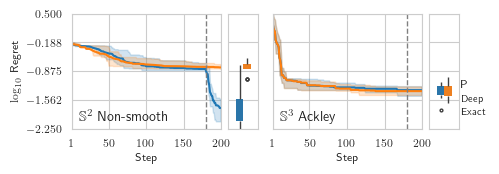

INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No L

In [23]:
import matplotlib.gridspec as gridspec

hue_order = ['deep', 'exact']
palette = sns.color_palette("tab10", len(hue_order))
data = df[perm_sph_harm & run_10_max]
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'


# Set up the gridspec

fig = plt.figure(figsize=(5, 1.5))
gs = gridspec.GridSpec(1, 5, width_ratios=[5, 1, 0., 5, 1])
gs.update(wspace=0.1) 

# Create the main line plot on the left
ax1 = plt.subplot(gs[0])
sns.lineplot(data=data, x='step', y='simple_regret', hue='model_arguments.model_name', estimator='mean', errorbar=('pi', 50), hue_order=hue_order, palette=palette, ax=ax1)

# Setting the y-axis range and ticks for the main plot
ax1.set_ylim(-2.25, 0.5)
ax1.set_yticks(np.linspace(-2.25, 0.5, 5))
ax1.set_xlim(1, 200)
ax1.set_xticks(np.linspace(1, 200, 5))

# Renaming the axes with updated font sizes for the main plot
ax1.set_xlabel("Step", fontsize=8)
ax1.set_ylabel("$\log_{10}$ Regret", fontsize=8)

# Update tick font sizes for the main plot
ax1.tick_params(labelsize=8)
ax1.set_xticks([1, 50, 100, 150, 200])

ax1.axvline(180, linestyle='--', color='gray', linewidth=1)

# Boxplot styling
boxprops = dict(edgecolor='none')
whiskerprops = dict(linewidth=1)  # using black as a placeholder
medianprops = dict(color='none')
flierprops= dict(marker="o", markersize=2)

# Create the boxplot on the right
ax2 = plt.subplot(gs[1], sharey=ax1)
sns.boxplot(data=data[data['step'] == 199], y='simple_regret', hue='model_arguments.model_name', ax=ax2, 
            boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, showcaps=False, legend=False, 
            saturation=0.85, flierprops=flierprops, width=0.5)

# Modify the legend title
ax1.legend().remove()


ax2.set(xticklabels=[], ylabel="", xlabel="")  # Remove x and y axis labels
for label in ax2.get_yticklabels():
    label.set_visible(False)
ax2.tick_params(left=False, bottom=False)  # Remove ticks
# ax1.set_title("Non-smooth Minimum", fontsize=9)



### SECOND PLOT

data = df[ackley & run_10_max]

# Create the main line plot on the left
ax3 = plt.subplot(gs[-2], sharey=ax1)
sns.lineplot(data=data, x='step', y='simple_regret', hue='model_arguments.model_name', estimator='mean', 
errorbar=('pi', 50), hue_order=hue_order, palette=palette, ax=ax3)

# Setting the y-axis range and ticks for the main plot
ax3.set_ylim(-2.25, 0.5)
ax3.set_yticks(np.linspace(-2.25, 0.5, 5))
ax3.set_xlim(1, 200)
ax3.set_xticks(np.linspace(1, 200, 5))

# Renaming the axes with updated font sizes for the main plot
ax3.set_xlabel("Step", fontsize=8)
ax3.set_ylabel("", fontsize=8)

# Update tick font sizes for the main plot
ax3.tick_params(labelsize=8)
ax3.set_xticks([1, 50, 100, 150, 200])

ax3.axvline(180, linestyle='--', color='gray', linewidth=1)


# Create the boxplot on the right
ax4 = plt.subplot(gs[-1], sharey=ax1)
sns.boxplot(data=data[data['step'] == 199], y='simple_regret', hue='model_arguments.model_name', ax=ax4, 
            boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, showcaps=False, legend=False, 
            saturation=0.85, flierprops=flierprops, width=0.5)

# Adjust positions of the boxes to create space between them
for i, artist in enumerate(ax4.artists):
    # This adjusts the boxes' positions
    artist.set_x(artist.get_x() + (-0.5 if i % 2 == 0 else 0.2))

# Modify the legend title
handles, labels = ax3.get_legend_handles_labels()
labels = ['Deep', 'Exact']
legend = ax3.legend(handles=handles, labels=labels, fontsize=7, title_fontsize=8, 
                    loc='center left', bbox_to_anchor=(1.25, 0.5), frameon=False)
legend.set_title("GP")

ax4.set(xticklabels=[], ylabel="", xlabel="")  # Remove x and y axis labels
for label in ax4.get_yticklabels():
    label.set_visible(False)
for label in ax3.get_yticklabels():
    label.set_visible(False)
ax3.tick_params(axis='y', which='both', length=0)
# ax3.set_title("Smooth Minimum", fontsize=9)

ax4.tick_params(left=False, bottom=False)  # Remove ticks

delta = 0.05
ax3.annotate(r'$\mathbb{S}^3$ Ackley', xy=(delta, delta), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
ax1.annotate(r'$\mathbb{S}^2$ Non-smooth', xy=(delta, delta), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')


# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()
fig.savefig('./plots/bo_comparison_plot_transparent.pdf', format='pdf', bbox_inches='tight', dpi=600, transparent=True)

/tmp/ipykernel_999/2082794483.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df[perm_sph_harm & run_10_max]
/tmp/ipykernel_999/2082794483.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df[ackley & run_10_max]
/tmp/ipykernel_999/2082794483.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using

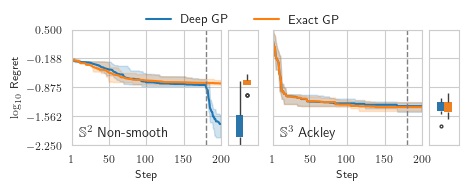

INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
INFO: No L

In [36]:
import matplotlib.gridspec as gridspec

hue_order = ['deep', 'exact']
palette = sns.color_palette("tab10", len(hue_order))
data = df[perm_sph_harm & run_10_max]
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'


# Set up the gridspec

fig = plt.figure(figsize=(5, 1.5))
gs = gridspec.GridSpec(1, 5, width_ratios=[5, 1, 0., 5, 1])
gs.update(wspace=0.1) 

# Create the main line plot on the left
ax1 = plt.subplot(gs[0])
sns.lineplot(data=data, x='step', y='simple_regret', hue='model_arguments.model_name', estimator='mean', errorbar=('pi', 50), hue_order=hue_order, palette=palette, ax=ax1)

# Setting the y-axis range and ticks for the main plot
ax1.set_ylim(-2.25, 0.5)
ax1.set_yticks(np.linspace(-2.25, 0.5, 5))
ax1.set_xlim(1, 200)
ax1.set_xticks(np.linspace(1, 200, 5))

# Renaming the axes with updated font sizes for the main plot
ax1.set_xlabel("Step", fontsize=8)
ax1.set_ylabel("$\log_{10}$ Regret", fontsize=8)

# Update tick font sizes for the main plot
ax1.tick_params(labelsize=8)
ax1.set_xticks([1, 50, 100, 150, 200])

ax1.axvline(180, linestyle='--', color='gray', linewidth=1)

# Boxplot styling
boxprops = dict(edgecolor='none')
whiskerprops = dict(linewidth=1)  # using black as a placeholder
medianprops = dict(color='none')
flierprops= dict(marker="o", markersize=2)

# Create the boxplot on the right
ax2 = plt.subplot(gs[1], sharey=ax1)
sns.boxplot(data=data[data['step'] == 199], y='simple_regret', hue='model_arguments.model_name', ax=ax2, 
            boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, showcaps=False, legend=False, 
            saturation=0.85, flierprops=flierprops, width=0.5)

# Modify the legend title
ax1.legend().remove()


ax2.set(xticklabels=[], ylabel="", xlabel="")  # Remove x and y axis labels
for label in ax2.get_yticklabels():
    label.set_visible(False)
ax2.tick_params(left=False, bottom=False)  # Remove ticks
# ax1.set_title("Non-smooth Minimum", fontsize=9)



### SECOND PLOT

data = df[ackley & run_10_max]

# Create the main line plot on the left
ax3 = plt.subplot(gs[-2], sharey=ax1)
sns.lineplot(data=data, x='step', y='simple_regret', hue='model_arguments.model_name', estimator='mean', 
errorbar=('pi', 50), hue_order=hue_order, palette=palette, ax=ax3)

# Setting the y-axis range and ticks for the main plot
ax3.set_ylim(-2.25, 0.5)
ax3.set_yticks(np.linspace(-2.25, 0.5, 5))
ax3.set_xlim(1, 200)
ax3.set_xticks(np.linspace(1, 200, 5))

# Renaming the axes with updated font sizes for the main plot
ax3.set_xlabel("Step", fontsize=8)
ax3.set_ylabel("", fontsize=8)

# Update tick font sizes for the main plot
ax3.tick_params(labelsize=8)
ax3.set_xticks([1, 50, 100, 150, 200])

ax3.axvline(180, linestyle='--', color='gray', linewidth=1)


# Create the boxplot on the right
ax4 = plt.subplot(gs[-1], sharey=ax1)
sns.boxplot(data=data[data['step'] == 199], y='simple_regret', hue='model_arguments.model_name', ax=ax4, 
            boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, showcaps=False, legend=False, 
            saturation=0.85, flierprops=flierprops, width=0.5)

# Adjust positions of the boxes to create space between them
for i, artist in enumerate(ax4.artists):
    # This adjusts the boxes' positions
    artist.set_x(artist.get_x() + (-0.5 if i % 2 == 0 else 0.2))

# Modify the legend title
handles, labels = ax3.get_legend_handles_labels()
labels = ['Deep GP', 'Exact GP']
legend = ax3.legend(handles=handles, labels=labels, fontsize=9, title_fontsize=8, 
                    loc='upper center', bbox_to_anchor=(-0.2, 1.23), ncol=2, frameon=False)
# legend.set_title("GP")

ax4.set(xticklabels=[], ylabel="", xlabel="")  # Remove x and y axis labels
for label in ax4.get_yticklabels():
    label.set_visible(False)
for label in ax3.get_yticklabels():
    label.set_visible(False)
ax3.tick_params(axis='y', which='both', length=0)
# ax3.set_title("Smooth Minimum", fontsize=9)

ax4.tick_params(left=False, bottom=False)  # Remove ticks

delta = 0.05
ax3.annotate(r'$\mathbb{S}^3$ Ackley', xy=(delta, delta), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
ax1.annotate(r'$\mathbb{S}^2$ Non-smooth', xy=(delta, delta), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')


# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()
fig.savefig('./plots/bo_comparison_plot_transparent.pdf', format='pdf', bbox_inches='tight', dpi=600, transparent=True)